In [1]:
import torch
from transformers import pipeline
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import LabelEncoder
from sklearn.base import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
dataset_path = "../data/jogosLoL2021.csv"
df = pd.read_csv(dataset_path, sep=',')
df.head()

,id,result,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,golddiffat10,xpdiffat10,csdiffat10,...,OPP_EGR,OPP_MLR,OPP_FB%,OPP_FT%,OPP_F3T%,OPP_HLD%,OPP_DRG%,OPP_BN%,OPP_LNE%,OPP_JNG%
0,10,1,5018.0,4255.0,86.0,5.0,9.0,1793.0,2365.0,65.0,...,23.1,-23.1,0,0,33,50,27,0,49.2,43.7
1,22,0,573.0,-1879.0,-49.0,1.0,4.0,759.0,171.0,-8.0,...,77.2,22.8,100,100,100,58,70,89,50.4,53.3
2,34,0,-579.0,-1643.0,-40.0,-1.0,-5.0,73.0,-1.0,-24.0,...,77.2,22.8,100,100,100,58,70,89,50.4,53.3
3,106,1,3739.0,1118.0,53.0,1.0,0.0,1746.0,824.0,21.0,...,63.9,-3.9,67,67,67,48,60,48,51.6,50.3
4,118,0,-6390.0,-4569.0,-47.0,-10.0,-17.0,-3500.0,-1882.0,-18.0,...,25.8,-0.8,13,25,25,19,20,20,49.7,42.2


In [3]:
df.drop(columns="id", inplace=True)
df.dropna(inplace=True)

In [4]:
df.describe()

,result,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,golddiffat10,xpdiffat10,csdiffat10,killsdiffat10,...,OPP_EGR,OPP_MLR,OPP_FB%,OPP_FT%,OPP_F3T%,OPP_HLD%,OPP_DRG%,OPP_BN%,OPP_LNE%,OPP_JNG%
count,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,...,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000,8152.000000
mean,0.531894,276.489328,4.800417,-0.348135,0.173332,0.311089,102.689892,32.706452,0.719946,0.090898,...,44.814009,-6.222031,48.298945,43.971663,42.174681,45.288027,45.828754,41.541830,49.774583,48.389561
std,0.499012,3092.939045,2164.253849,41.919732,3.769752,7.180593,1520.042590,1138.075319,27.248651,2.371612,...,14.794485,16.023668,20.784422,22.695632,24.110996,18.265473,13.370805,21.333411,1.044415,4.023629
min,0.000000,-13908.000000,-10397.000000,-181.000000,-22.000000,-34.000000,-7632.000000,-5829.000000,-109.000000,-15.000000,...,3.100000,-59.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.300000,35.500000
25%,0.000000,-1685.250000,-1344.250000,-27.000000,-2.000000,-4.000000,-865.000000,-691.250000,-17.000000,-1.000000,...,35.100000,-15.200000,33.000000,30.000000,25.000000,33.000000,39.000000,29.000000,49.200000,45.900000
50%,1.000000,313.500000,26.000000,0.000000,0.000000,0.000000,115.000000,26.000000,1.000000,0.000000,...,44.800000,-5.900000,50.000000,43.000000,43.000000,48.000000,46.000000,43.000000,49.700000,48.700000
75%,1.000000,2247.000000,1334.250000,26.000000,2.000000,4.000000,1037.500000,754.000000,19.000000,1.000000,...,53.400000,4.100000,61.000000,59.000000,58.000000,58.000000,54.000000,56.000000,50.300000,50.800000
max,1.000000,13855.000000,11914.000000,183.000000,21.000000,32.000000,7043.000000,6464.000000,137.000000,13.000000,...,98.100000,49.400000,100.000000,100.000000,100.000000,100.000000,94.000000,100.000000,55.300000,64.800000


---

Definição de seeds, variaveis, ...

In [5]:
np.random.seed(42)
TARGET = "result"
PRE_GAME_FEATURES = [
    'WR', 'KD', 'GPR', 'GSPD', 'EGR', 'MLR', 'FB%', 'FT%', 'F3T%', 
    'HLD%', 'DRG%', 'BN%', 'LNE%', 'JNG%',
    'OPP_WR', 'OPP_KD', 'OPP_GPR', 'OPP_GSPD', 'OPP_EGR', 'OPP_MLR',
    'OPP_FB%', 'OPP_FT%', 'OPP_F3T%', 'OPP_HLD%', 'OPP_DRG%', 
    'OPP_BN%', 'OPP_LNE%', 'OPP_JNG%'
]

AT_10M_FEATURES = [
    'golddiffat10',
    'xpdiffat10',
    'csdiffat10',   
    'killsdiffat10',
    'assistsdiffat10'
]

AT_15M_FEATURES = [
    'golddiffat15', 'xpdiffat15', 'csdiffat15', 
    'killsdiffat15', 'assistsdiffat15'
]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
# Example: Move a tensor to the selected device
# tensor = torch.tensor([1.0, 2.0, 3.0]).to(device)

Using device: cuda


In [6]:
# Se há colunas categóricas que precisam ser codificadas:
feature_columns = None   
le = LabelEncoder()

# Separar features e target
if feature_columns is None:
    X = df.drop(columns=[TARGET]).values
    feature_names = df.drop(columns=[TARGET]).columns.tolist()
else:
    X = df[feature_columns].values
    feature_names = feature_columns

y = df[TARGET].values

In [7]:
# Informações do dataset
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
class_distribution = np.bincount(y)

print(f"Dataset carregado: {n_samples} amostras, {n_features} features, {n_classes} classes")
print(f"Distribuição das classes: {dict(zip(range(n_classes), class_distribution))}")
print(f"Features: {feature_names[:5]}{'...' if len(feature_names) > 5 else ''}")

Dataset carregado: 8152 amostras, 38 features, 2 classes
Distribuição das classes: {0: np.int64(3816), 1: np.int64(4336)}
Features: ['golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsdiffat15', 'assistsdiffat15']...


---

## Random Forest

In [8]:
def nested_cv_random_forest(
    df, 
    feature_columns, 
    target_column='result', 
    rf_hyperparameters=None, 
    n_classes=2, 
    n_outer_folds=10, 
    n_inner_folds=4, 
    n_rounds=3, 
    random_state=36854321
):
    if rf_hyperparameters is None:
        rf_hyperparameters = {'n_estimators': [5, 10, 15, 25], 'max_depth': [10, None]}
    print(f"Grid de hiperparâmetros: {np.prod([len(v) for v in rf_hyperparameters.values()])} combinações")

    X = df[feature_columns].values
    y = df[target_column].values

    resultados_completos = defaultdict(list)
    detalhes_rodadas = []

    for rodada in range(n_rounds):
        print(f"\nRODADA {rodada + 1}/{n_rounds}")
        print("-" * 40)

        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_state)
        acuracias_fold_externo = []
        detalhes_folds = []

        for fold_externo, (train_idx, test_idx) in enumerate(outer_cv.split(X_shuffled, y_shuffled)):
            print(f"Fold Externo {fold_externo + 1}/{n_outer_folds}", end=" - ")

            X_train_outer = X_shuffled[train_idx]
            X_test_outer = X_shuffled[test_idx]
            y_train_outer = y_shuffled[train_idx]
            y_test_outer = y_shuffled[test_idx]

            train_dist = np.bincount(y_train_outer, minlength=n_classes)
            test_dist = np.bincount(y_test_outer, minlength=n_classes)

            inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_state)

            rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
            grid_search = GridSearchCV(
                rf,
                rf_hyperparameters,
                cv=inner_cv,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            ) # Otimiza hiperparâmetros para cada fold externo e usa validação cruzada interna (4 folds) -> perforance melhorada
            
            grid_search.fit(X_train_outer, y_train_outer)
            y_pred = grid_search.predict(X_test_outer)
            acuracia = accuracy_score(y_test_outer, y_pred)
            acuracias_fold_externo.append(acuracia)

            detalhes_fold = {
                'fold': fold_externo + 1,
                'melhores_params': grid_search.best_params_,
                'acuracia_validacao_interna': grid_search.best_score_,
                'acuracia_teste_externo': acuracia,
                'tamanho_treino': len(X_train_outer),
                'tamanho_teste': len(X_test_outer),
                'distribuicao_treino': train_dist.tolist(),
                'distribuicao_teste': test_dist.tolist()
            }
            detalhes_folds.append(detalhes_fold)

            print(f"Acurácia: {acuracia:.4f} | Val.Interna: {grid_search.best_score_:.4f}")

        acuracia_media_rodada = np.mean(acuracias_fold_externo)
        desvio_rodada = np.std(acuracias_fold_externo)

        print(f"\n  Resultados da Rodada {rodada + 1}:")
        print(f"     Acurácia Média: {acuracia_media_rodada:.4f} ± {desvio_rodada:.4f}")
        print(f"     Min: {min(acuracias_fold_externo):.4f} | Max: {max(acuracias_fold_externo):.4f}")

        resultados_completos['rodada'].append(rodada + 1)
        resultados_completos['acuracia_media'].append(acuracia_media_rodada)
        resultados_completos['desvio_padrao'].append(desvio_rodada)
        resultados_completos['acuracias_folds'].append(acuracias_fold_externo)

        detalhes_rodadas.append({
            'rodada': rodada + 1,
            'acuracia_media': acuracia_media_rodada,
            'desvio_padrao': desvio_rodada,
            'detalhes_folds': detalhes_folds
        })

    print("\n" + "="*60)
    print("RESULTADO FINAL DAS 3 RODADAS")
    print("="*60)

    acuracias_finais = resultados_completos['acuracia_media']
    acuracia_final_media = np.mean(acuracias_finais)
    desvio_final = np.std(acuracias_finais)

    print(f"Acurácia Final do Random Forest: {acuracia_final_media:.4f} ± {desvio_final:.4f}")
    print(f"Intervalo de Confiança (~95%): [{acuracia_final_media - 2*desvio_final:.4f}, {acuracia_final_media + 2*desvio_final:.4f}]")

    return {
        'resultados_completos': resultados_completos,
        'detalhes_rodadas': detalhes_rodadas,
        'acuracia_final_media': acuracia_final_media,
        'desvio_final': desvio_final
    }


In [9]:
def nested_cv_classifier(
    df, 
    feature_columns, 
    classifier,
    classifier_name,
    hyperparameters,
    target_column='result', 
    n_classes=2, 
    n_outer_folds=10, 
    n_inner_folds=4, 
    n_rounds=3, 
    random_state=36854321
):
    """
    Função genérica para validação cruzada aninhada com qualquer classificador
    
    Parâmetros:
    - df: DataFrame com os dados
    - feature_columns: lista das colunas de features
    - classifier: instância do classificador (ex: RandomForestClassifier(), MLPClassifier())
    - classifier_name: nome do classificador para exibição (ex: 'Random Forest', 'MLP', 'KNN')
    - hyperparameters: dicionário com hiperparâmetros do classificador
    - target_column: nome da coluna target (padrão: 'result')
    - n_classes: número de classes (padrão: 2)
    - n_outer_folds: número de folds externos (padrão: 10)
    - n_inner_folds: número de folds internos (padrão: 4)
    - n_rounds: número de rodadas (padrão: 3)
    - random_state: seed para reprodutibilidade
    """
    
    print(f"Grid de hiperparâmetros: {np.prod([len(v) for v in hyperparameters.values()])} combinações")
    print(f"Classificador: {classifier_name}")

    X = df[feature_columns].values
    y = df[target_column].values

    resultados_completos = defaultdict(list)
    detalhes_rodadas = []

    for rodada in range(n_rounds):
        print(f"\nRODADA {rodada + 1}/{n_rounds}")
        print("-" * 40)

        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_state)
        acuracias_fold_externo = []
        detalhes_folds = []

        for fold_externo, (train_idx, test_idx) in enumerate(outer_cv.split(X_shuffled, y_shuffled)):
            print(f"Fold Externo {fold_externo + 1}/{n_outer_folds}", end=" - ")

            X_train_outer = X_shuffled[train_idx]
            X_test_outer = X_shuffled[test_idx]
            y_train_outer = y_shuffled[train_idx]
            y_test_outer = y_shuffled[test_idx]

            train_dist = np.bincount(y_train_outer, minlength=n_classes)
            test_dist = np.bincount(y_test_outer, minlength=n_classes)

            inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_state)

            # Clona o classificador para cada fold para evitar problemas de estado
            from sklearn.base import clone
            clf = clone(classifier)
            
            grid_search = GridSearchCV(
                clf,
                hyperparameters,
                cv=inner_cv,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            ) # Otimiza hiperparâmetros para cada fold externo e usa validação cruzada interna (4 folds) -> performance melhorada
            
            grid_search.fit(X_train_outer, y_train_outer)
            y_pred = grid_search.predict(X_test_outer)
            acuracia = accuracy_score(y_test_outer, y_pred)
            acuracias_fold_externo.append(acuracia)

            detalhes_fold = {
                'fold': fold_externo + 1,
                'melhores_params': grid_search.best_params_,
                'acuracia_validacao_interna': grid_search.best_score_,
                'acuracia_teste_externo': acuracia,
                'tamanho_treino': len(X_train_outer),
                'tamanho_teste': len(X_test_outer),
                'distribuicao_treino': train_dist.tolist(),
                'distribuicao_teste': test_dist.tolist()
            }
            detalhes_folds.append(detalhes_fold)

            print(f"Acurácia: {acuracia:.4f} | Val.Interna: {grid_search.best_score_:.4f}")

        acuracia_media_rodada = np.mean(acuracias_fold_externo)
        desvio_rodada = np.std(acuracias_fold_externo)

        print(f"\n  Resultados da Rodada {rodada + 1}:")
        print(f"     Acurácia Média: {acuracia_media_rodada:.4f} ± {desvio_rodada:.4f}")
        print(f"     Min: {min(acuracias_fold_externo):.4f} | Max: {max(acuracias_fold_externo):.4f}")

        resultados_completos['rodada'].append(rodada + 1)
        resultados_completos['acuracia_media'].append(acuracia_media_rodada)
        resultados_completos['desvio_padrao'].append(desvio_rodada)
        resultados_completos['acuracias_folds'].append(acuracias_fold_externo)

        detalhes_rodadas.append({
            'rodada': rodada + 1,
            'acuracia_media': acuracia_media_rodada,
            'desvio_padrao': desvio_rodada,
            'detalhes_folds': detalhes_folds
        })

    print("\n" + "="*60)
    print("RESULTADO FINAL DAS 3 RODADAS")
    print("="*60)

    acuracias_finais = resultados_completos['acuracia_media']
    acuracia_final_media = np.mean(acuracias_finais)
    desvio_final = np.std(acuracias_finais)

    print(f"Acurácia Final do {classifier_name}: {acuracia_final_media:.4f} ± {desvio_final:.4f}")
    print(f"Intervalo de Confiança (~95%): [{acuracia_final_media - 2*desvio_final:.4f}, {acuracia_final_media + 2*desvio_final:.4f}]")

    return {
        'resultados_completos': resultados_completos,
        'detalhes_rodadas': detalhes_rodadas,
        'acuracia_final_media': acuracia_final_media,
        'desvio_final': desvio_final,
        'classifier_name': classifier_name
    }

---
# HeterogeneousBoostingClassifier

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.multiclass import unique_labels
from collections import Counter
import warnings

class HeterogeneousBoostingClassifier(BaseEstimator, ClassifierMixin):
    """
    Heterogeneous Boosting Classifier
    
    Um classificador ensemble que combina diferentes tipos de classificadores base
    (Decision Tree, Naive Bayes, MLP, KNN) usando boosting com votação majoritária.
    
    Parameters
    ----------
    n_estimators : int, default=10
        Número de classificadores base que comporão o ensemble.
    
    random_state : int, RandomState instance or None, default=None
        Controla a aleatoriedade da seleção de exemplos com reposição.
    
    Attributes
    ----------
    classes_ : ndarray of shape (n_classes,)
        As classes únicas encontradas durante o ajuste.
    
    n_classes_ : int
        Número de classes.
    
    most_frequent_class_ : class label
        A classe mais frequente na base de treino.
    
    estimators_ : list
        Lista dos classificadores selecionados para o ensemble.
    
    X_train_ : ndarray
        Dados de treino originais armazenados para referência.
    
    y_train_ : ndarray
        Rótulos de treino originais armazenados para referência.
    """
    
    def __init__(self, n_estimators=10, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state
    
    def _create_base_classifiers(self):
        """Cria os classificadores base com parâmetros default do sklearn"""
        return {
            'NB': GaussianNB(),
            'DT': DecisionTreeClassifier(random_state=self.random_state),
            'MLP': MLPClassifier(random_state=self.random_state, max_iter=1000),
            'KNN': KNeighborsClassifier()
        }
    
    def _roulette_wheel_selection(self, X, y, weights):
        """
        Seleciona exemplos com reposição usando o método da roleta
        baseado nos pesos dos exemplos.
        """
        n_samples = X.shape[0]
        
        # Verifica se há pesos inválidos (NaN, inf, ou negativos)
        if np.any(np.isnan(weights)) or np.any(np.isinf(weights)) or np.any(weights < 0):
            # Se há pesos inválidos, reinicia com pesos uniformes
            weights = np.ones(n_samples, dtype=float)
        
        # Verifica se todos os pesos são zero
        if np.sum(weights) == 0:
            weights = np.ones(n_samples, dtype=float)
        
        # Normaliza os pesos para que somem 1
        normalized_weights = weights / np.sum(weights)
        
        # Verifica novamente se a normalização gerou NaN
        if np.any(np.isnan(normalized_weights)):
            normalized_weights = np.ones(n_samples, dtype=float) / n_samples
        
        # Seleciona índices com base nos pesos (com reposição)
        selected_indices = np.random.choice(
            n_samples, 
            size=n_samples, 
            replace=True, 
            p=normalized_weights
        )
        
        return X[selected_indices], y[selected_indices], selected_indices
    
    def _evaluate_classifier(self, classifier, X_train, y_train):
        """
        Treina e avalia o desempenho de um classificador nos dados de treino
        """
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                warnings.filterwarnings("ignore", category=FutureWarning)
                # Treina o classificador
                classifier.fit(X_train, y_train)
                # Testa no mesmo conjunto (conforme pseudocódigo)
                predictions = classifier.predict(X_train)
                # Calcula acurácia
                accuracy = np.mean(predictions == y_train)
                return accuracy, predictions, classifier
        except Exception as e:
            # Em caso de erro, retorna acurácia 0
            print(f"Erro ao treinar classificador: {e}")
            return 0.0, np.full(len(y_train), y_train[0]), classifier
    
    def _select_best_classifier(self, results):
        """
        Seleciona o melhor classificador baseado na acurácia.
        Em caso de empate, usa a preferência: MLP, DT, KNN, NB
        """
        preference_order = ['MLP', 'DT', 'KNN', 'NB']
        
        # Encontra a melhor acurácia
        max_accuracy = max(acc for acc, _, _, _ in results.values())
        
        # Encontra classificadores com melhor acurácia
        best_classifiers = [name for name, (acc, _, _, _) in results.items() 
                          if acc == max_accuracy]
        
        # Aplica ordem de preferência em caso de empate
        for preferred in preference_order:
            if preferred in best_classifiers:
                return preferred, results[preferred]
        
        # Fallback (não deveria acontecer)
        return list(best_classifiers)[0], results[list(best_classifiers)[0]]
    
    def fit(self, X, y):
        """
        Ajusta o classificador Heterogeneous Boosting.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados de treino.
        y : array-like of shape (n_samples,)
            Rótulos de treino.
        
        Returns
        -------
        self : object
            Retorna self.
        """
        # Validação de entrada
        X, y = check_X_y(X, y)
        
        # Armazena dados de treino originais
        self.X_train_ = X.copy()
        self.y_train_ = y.copy()
        
        # Armazena classes únicas
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        
        # Encontra e guarda a classe mais frequente
        class_counts = Counter(y)
        self.most_frequent_class_ = class_counts.most_common(1)[0][0]
        
        # Inicializa pesos dos exemplos com valor 1 para todos
        weights = np.ones(X.shape[0], dtype=float)
        
        # Inicializa lista de classificadores do ensemble
        self.estimators_ = []
        
        # Configura random state para reprodutibilidade
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Repete n_estimators vezes
        for iteration in range(self.n_estimators):
            # CORREÇÃO: Primeiro classificador usa base original, demais usam seleção com roleta
            if iteration == 0:
                # Primeiro classificador: usa base de treino original
                X_train_iter = X
                y_train_iter = y
                selected_indices = np.arange(len(y))
            else:
                # Demais classificadores: usa seleção com método da roleta
                X_train_iter, y_train_iter, selected_indices = self._roulette_wheel_selection(X, y, weights)
            
            # Para cada um dos métodos de classificação (NB, DT, MLP, KNN)
            base_classifiers = self._create_base_classifiers()
            results = {}
            
            for name, classifier in base_classifiers.items():
                # Treina e testa o classificador nos exemplos selecionados
                accuracy, predictions, trained_classifier = self._evaluate_classifier(
                    classifier, X_train_iter, y_train_iter
                )
                results[name] = (accuracy, predictions, trained_classifier, selected_indices)
            
            # Escolhe o classificador com melhor desempenho
            best_name, (best_accuracy, best_predictions, best_classifier, best_indices) = \
                self._select_best_classifier(results)
            
            # Adiciona o melhor classificador ao combinado
            self.estimators_.append(best_classifier)
            
            # Dobra o peso dos exemplos classificados de forma errônea
            # CORREÇÃO: Para o primeiro classificador, usar índices diretos
            if iteration == 0:
                # Primeiro classificador: atualiza pesos baseado na predição na base original
                for i in range(len(y)):
                    if best_predictions[i] != y[i]:
                        weights[i] *= 2.0
            else:
                # Demais classificadores: atualiza pesos dos exemplos originais correspondentes
                for i, original_idx in enumerate(best_indices):
                    if best_predictions[i] != y_train_iter[i]:
                        weights[original_idx] *= 2.0
            
            # Verifica se os pesos se tornaram muito grandes (overflow protection)
            if np.any(weights > 1e10):
                weights = weights / np.max(weights) * 1000
        
        return self
    
    def predict(self, X):
        """
        Prediz classes para as amostras em X usando votação majoritária.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Amostras para predição.
        
        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Classes preditas.
        """
        # Validação de entrada
        X = check_array(X)
        
        # Verifica se o modelo foi treinado
        if not hasattr(self, 'estimators_') or len(self.estimators_) == 0:
            raise ValueError("Este modelo não foi treinado ainda. Chame 'fit' antes de fazer predições.")
        
        # Para cada um dos classificadores individuais do combinado
        all_predictions = []
        for estimator in self.estimators_:
            try:
                # Obter a classificação do exemplo usando o classificador individual
                predictions = estimator.predict(X)
                all_predictions.append(predictions)
            except Exception as e:
                # Em caso de erro, usa a classe mais frequente
                predictions = np.full(X.shape[0], self.most_frequent_class_)
                all_predictions.append(predictions)
        
        # Se não há predições válidas, retorna classe mais frequente
        if len(all_predictions) == 0:
            return np.full(X.shape[0], self.most_frequent_class_)
        
        # Transpõe para ter predições por amostra
        all_predictions = np.array(all_predictions).T
        
        # Para cada exemplo, aplica votação majoritária
        final_predictions = []
        for sample_predictions in all_predictions:
            # Contar quantas vezes cada classe foi selecionada
            vote_counts = Counter(sample_predictions)
            max_votes = max(vote_counts.values())
            
            # Obter a(s) mais votada(s)
            most_voted_classes = [cls for cls, votes in vote_counts.items() 
                                if votes == max_votes]
            
            # Se mais de uma classe for a mais votada
            if len(most_voted_classes) > 1:
                # Retornar a classe mais frequente na base de treino dentre as que empataram
                if self.most_frequent_class_ in most_voted_classes:
                    final_predictions.append(self.most_frequent_class_)
                else:
                    # Se a classe mais frequente não está no empate, escolhe a primeira
                    final_predictions.append(most_voted_classes[0])
            else:
                # Retornar a classe mais votada
                final_predictions.append(most_voted_classes[0])
        
        return np.array(final_predictions)
    
    def predict_proba(self, X):
        """
        Prediz probabilidades de classe para as amostras em X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Amostras para predição.
        
        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes)
            Probabilidades de cada classe para cada amostra.
        """
        # Validação de entrada
        X = check_array(X)
        
        # Verifica se o modelo foi treinado
        if not hasattr(self, 'estimators_') or len(self.estimators_) == 0:
            raise ValueError("Este modelo não foi treinado ainda. Chame 'fit' antes de fazer predições.")
        
        # Obtém predições de todos os classificadores do ensemble
        all_predictions = []
        for estimator in self.estimators_:
            try:
                predictions = estimator.predict(X)
                all_predictions.append(predictions)
            except Exception as e:
                # Em caso de erro, usa a classe mais frequente
                predictions = np.full(X.shape[0], self.most_frequent_class_)
                all_predictions.append(predictions)
        
        # Se não há predições válidas, retorna probabilidade 1 para classe mais frequente
        if len(all_predictions) == 0:
            probabilities = np.zeros((X.shape[0], self.n_classes_))
            most_frequent_idx = np.where(self.classes_ == self.most_frequent_class_)[0][0]
            probabilities[:, most_frequent_idx] = 1.0
            return probabilities
        
        # Transpõe para ter predições por amostra
        all_predictions = np.array(all_predictions).T
        
        # Calcula probabilidades baseadas na proporção de votos
        probabilities = []
        for sample_predictions in all_predictions:
            vote_counts = Counter(sample_predictions)
            total_votes = len(sample_predictions)
            
            # Cria vetor de probabilidades para todas as classes
            sample_proba = np.zeros(self.n_classes_)
            for i, cls in enumerate(self.classes_):
                sample_proba[i] = vote_counts.get(cls, 0) / total_votes
            
            probabilities.append(sample_proba)
        
        return np.array(probabilities)
    
    def score(self, X, y):
        """
        Retorna a acurácia média nas amostras de teste dadas.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Amostras de teste.
        y : array-like of shape (n_samples,)
            Rótulos verdadeiros para X.
        
        Returns
        -------
        score : float
            Acurácia média de self.predict(X) em relação a y.
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)

---
## Execução

In [11]:
print("Iniciando a validação cruzada aninhada com Random Forest...")

print(f"Resultado usando {len(PRE_GAME_FEATURES)} features pré-jogo e {n_classes} classes.")
resultados_rf_pre_jogo = nested_cv_random_forest(
    df, 
    feature_columns=PRE_GAME_FEATURES, 
    target_column=TARGET, 
    n_classes=n_classes, 
    n_outer_folds=10, 
    n_inner_folds=4, 
    n_rounds=3
)

Iniciando a validação cruzada aninhada com Random Forest...
Resultado usando 28 features pré-jogo e 2 classes.
Grid de hiperparâmetros: 8 combinações

RODADA 1/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.6164 | Val.Interna: 0.6043
Fold Externo 2/10 - Acurácia: 0.6042 | Val.Interna: 0.6140
Fold Externo 3/10 - Acurácia: 0.6123 | Val.Interna: 0.6054
Fold Externo 4/10 - Acurácia: 0.6380 | Val.Interna: 0.5938
Fold Externo 5/10 - Acurácia: 0.5816 | Val.Interna: 0.6171
Fold Externo 6/10 - Acurácia: 0.6221 | Val.Interna: 0.6116
Fold Externo 7/10 - Acurácia: 0.6331 | Val.Interna: 0.6060
Fold Externo 8/10 - Acurácia: 0.6049 | Val.Interna: 0.6136
Fold Externo 9/10 - Acurácia: 0.6147 | Val.Interna: 0.6120
Fold Externo 10/10 - Acurácia: 0.6025 | Val.Interna: 0.6092

  Resultados da Rodada 1:
     Acurácia Média: 0.6130 ± 0.0154
     Min: 0.5816 | Max: 0.6380

RODADA 2/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.6127 | Val.Interna: 0.6080

In [12]:
print("Iniciando a validação cruzada aninhada com KNN...")
print(f"Resultado usando {len(PRE_GAME_FEATURES)} features pré-jogo e {n_classes} classes.")

knn_hyperparams = {'n_neighbors':[1,3,5,7,9]}

resultados_knn_pre_jogo = nested_cv_classifier(
    df=df,
    feature_columns=PRE_GAME_FEATURES,
    classifier=KNeighborsClassifier(n_jobs=-1),
    classifier_name='KNN',
    hyperparameters=knn_hyperparams
)

Iniciando a validação cruzada aninhada com KNN...
Resultado usando 28 features pré-jogo e 2 classes.
Grid de hiperparâmetros: 5 combinações
Classificador: KNN

RODADA 1/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.5956 | Val.Interna: 0.5732
Fold Externo 2/10 - Acurácia: 0.6140 | Val.Interna: 0.5736
Fold Externo 3/10 - Acurácia: 0.5939 | Val.Interna: 0.5737
Fold Externo 4/10 - Acurácia: 0.5706 | Val.Interna: 0.5731
Fold Externo 5/10 - Acurácia: 0.5730 | Val.Interna: 0.5745
Fold Externo 6/10 - Acurácia: 0.5742 | Val.Interna: 0.5700
Fold Externo 7/10 - Acurácia: 0.5742 | Val.Interna: 0.5764
Fold Externo 8/10 - Acurácia: 0.5681 | Val.Interna: 0.5756
Fold Externo 9/10 - Acurácia: 0.5644 | Val.Interna: 0.5917
Fold Externo 10/10 - Acurácia: 0.5926 | Val.Interna: 0.5768

  Resultados da Rodada 1:
     Acurácia Média: 0.5821 ± 0.0152
     Min: 0.5644 | Max: 0.6140

RODADA 2/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.5625 | Val.Intern

In [13]:
print("Iniciando a validação cruzada aninhada com Decision Tree...")
print(f"Resultado usando {len(PRE_GAME_FEATURES)} features pré-jogo e {n_classes} classes.")

dt_hyperparams = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [5, 10, 15, 25]
}

resultados_dt_pre_jogo = nested_cv_classifier(
    df=df,
    feature_columns=PRE_GAME_FEATURES,
    classifier=DecisionTreeClassifier(random_state=36854321),
    classifier_name='Decision Tree',
    hyperparameters=dt_hyperparams
)

Iniciando a validação cruzada aninhada com Decision Tree...
Resultado usando 28 features pré-jogo e 2 classes.
Grid de hiperparâmetros: 8 combinações
Classificador: Decision Tree

RODADA 1/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.6152 | Val.Interna: 0.5915
Fold Externo 2/10 - Acurácia: 0.5870 | Val.Interna: 0.5931
Fold Externo 3/10 - Acurácia: 0.5791 | Val.Interna: 0.5857
Fold Externo 4/10 - Acurácia: 0.5963 | Val.Interna: 0.5956
Fold Externo 5/10 - Acurácia: 0.6037 | Val.Interna: 0.5966
Fold Externo 6/10 - Acurácia: 0.5840 | Val.Interna: 0.5941
Fold Externo 7/10 - Acurácia: 0.5730 | Val.Interna: 0.5889
Fold Externo 8/10 - Acurácia: 0.6110 | Val.Interna: 0.5878
Fold Externo 9/10 - Acurácia: 0.5963 | Val.Interna: 0.5959
Fold Externo 10/10 - Acurácia: 0.5595 | Val.Interna: 0.5915

  Resultados da Rodada 1:
     Acurácia Média: 0.5905 ± 0.0165
     Min: 0.5595 | Max: 0.6152

RODADA 2/3
----------------------------------------
Fold Externo 1/10 - Acurácia:

In [14]:
print("Iniciando a validação cruzada aninhada com Multi Layer Perceptron...")
print(f"Resultado usando {len(PRE_GAME_FEATURES)} features pré-jogo e {n_classes} classes.")

mlp_hyperparams = {
    'hidden_layer_sizes': [(100,), (10,)],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['constant', 'adaptive']
}

resultados_mlp_pre_jogo = nested_cv_classifier(
    df=df,
    feature_columns=PRE_GAME_FEATURES,
    classifier=MLPClassifier(random_state=36854321, max_iter=1000),
    classifier_name='Multi Layer Perceptron',
    hyperparameters=mlp_hyperparams
)

Iniciando a validação cruzada aninhada com Multi Layer Perceptron...
Resultado usando 28 features pré-jogo e 2 classes.
Grid de hiperparâmetros: 8 combinações
Classificador: Multi Layer Perceptron

RODADA 1/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.5490 | Val.Interna: 0.5802
Fold Externo 2/10 - Acurácia: 0.5821 | Val.Interna: 0.5871
Fold Externo 3/10 - Acurácia: 0.6086 | Val.Interna: 0.5899
Fold Externo 4/10 - Acurácia: 0.5840 | Val.Interna: 0.5817
Fold Externo 5/10 - Acurácia: 0.5914 | Val.Interna: 0.5858
Fold Externo 6/10 - Acurácia: 0.5804 | Val.Interna: 0.5893
Fold Externo 7/10 - Acurácia: 0.5877 | Val.Interna: 0.5898
Fold Externo 8/10 - Acurácia: 0.6012 | Val.Interna: 0.5857
Fold Externo 9/10 - Acurácia: 0.5816 | Val.Interna: 0.5865
Fold Externo 10/10 - Acurácia: 0.5865 | Val.Interna: 0.5891

  Resultados da Rodada 1:
     Acurácia Média: 0.5853 ± 0.0149
     Min: 0.5490 | Max: 0.6086

RODADA 2/3
----------------------------------------
Fold Extern

In [15]:
print("Iniciando a validação cruzada aninhada com Heterogeneous Boosting Classifier...")
print(f"Resultado usando {len(PRE_GAME_FEATURES)} features pré-jogo e {n_classes} classes.")

hb = HeterogeneousBoostingClassifier(n_estimators=5, random_state=36854321)
hb_hyperparams = {'n_estimators': [5, 10, 15, 25, 50]}

resultados_hb_pre_jogo = nested_cv_classifier(
    df=df,
    feature_columns=PRE_GAME_FEATURES,
    classifier=hb,
    classifier_name='Heterogeneous Boosting',
    hyperparameters=hb_hyperparams,
    target_column=TARGET,
    n_classes=n_classes,
    n_outer_folds=10,
    n_inner_folds=4,
    n_rounds=3
)

Iniciando a validação cruzada aninhada com Heterogeneous Boosting Classifier...
Resultado usando 28 features pré-jogo e 2 classes.
Grid de hiperparâmetros: 5 combinações
Classificador: Heterogeneous Boosting

RODADA 1/3
----------------------------------------
Fold Externo 1/10 - Acurácia: 0.5772 | Val.Interna: 0.5706
Fold Externo 2/10 - Acurácia: 0.5637 | Val.Interna: 0.5751
Fold Externo 3/10 - Acurácia: 0.5730 | Val.Interna: 0.5741
Fold Externo 4/10 - Acurácia: 0.5730 | Val.Interna: 0.5726
Fold Externo 5/10 - Acurácia: 0.5865 | Val.Interna: 0.5783
Fold Externo 6/10 - Acurácia: 0.5730 | Val.Interna: 0.5780
Fold Externo 7/10 - Acurácia: 0.6012 | Val.Interna: 0.5734
Fold Externo 8/10 - Acurácia: 0.5804 | Val.Interna: 0.5782
Fold Externo 9/10 - Acurácia: 0.5730 | Val.Interna: 0.5654
Fold Externo 10/10 - Acurácia: 0.5963 | Val.Interna: 0.5831

  Resultados da Rodada 1:
     Acurácia Média: 0.5797 ± 0.0111
     Min: 0.5637 | Max: 0.6012

RODADA 2/3
----------------------------------------


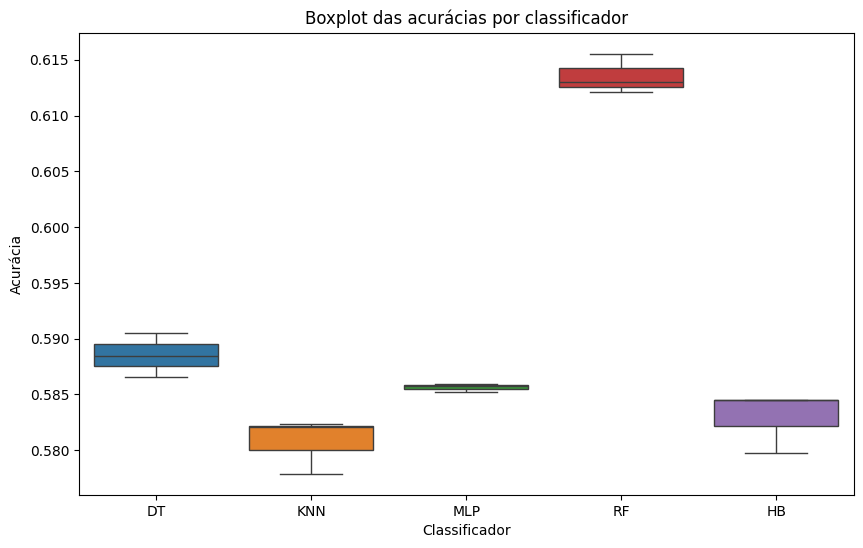

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

hb_scores =  resultados_hb_pre_jogo['resultados_completos']['acuracia_media']
dt_scores = resultados_dt_pre_jogo['resultados_completos']['acuracia_media']
knn_scores = resultados_knn_pre_jogo['resultados_completos']['acuracia_media']
mlp_scores = resultados_mlp_pre_jogo['resultados_completos']['acuracia_media']
rf_scores = resultados_rf_pre_jogo['resultados_completos']['acuracia_media']

# Resultados de cada classificador (exemplo com dicionário)
results = {
    'DT': dt_scores,
    'KNN': knn_scores,
    'MLP': mlp_scores,
    'RF': rf_scores,
    'HB': hb_scores
}

# Boxplot dos classificadores
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(results))
plt.title("Boxplot das acurácias por classificador")
plt.ylabel("Acurácia")
plt.xlabel("Classificador")
plt.show()


In [17]:

from scipy.stats import t
import numpy as np

def compute_stats(scores_dict, n_folds):
    summary = []
    for method, scores in scores_dict.items():
        mean = np.mean(scores)
        std = np.std(scores, ddof=1)
        ci = t.ppf(0.975, n_folds-1) * std / np.sqrt(n_folds)
        summary.append([method, round(mean, 4), round(std, 4),
                        round(mean - ci, 4), round(mean + ci, 4)])
    return pd.DataFrame(summary, columns=["Método", "Média", "Desvio Padrão", "Limite Inferior", "Limite Superior"])

stats_table = compute_stats(results, n_folds=10)
print(stats_table)


  Método   Média  Desvio Padrão  Limite Inferior  Limite Superior
0     DT  0.5885         0.0020           0.5871           0.5899
1    KNN  0.5808         0.0025           0.5790           0.5825
2    MLP  0.5857         0.0004           0.5854           0.5859
3     RF  0.6136         0.0018           0.6123           0.6148
4     HB  0.5829         0.0028           0.5810           0.5849


In [19]:
from scipy import stats
from scipy.stats import t
import numpy as np
import pandas as pd

# Função do teste t corrigido de Nadeau e Bengio
def t_corrigido_nadeau_bengio(data1, data2, X, n_folds_externos):
    N = len(X)
    n = len(data1)
    n_test = N // n_folds_externos
    n_train = N - n_test
    diffs = np.array(data1) - np.array(data2)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1)
    se_corrigido = std_diff * np.sqrt(1/n + n_test/n_train)
    t_stat = mean_diff / se_corrigido
    p_valor = 2 * (1 - t.cdf(abs(t_stat), df=n - 1))
    return t_stat, p_valor

# Preparar os dados
metodos = list(results.keys())  # results = {'DT': [...], 'KNN': [...], ...}
n_metodos = len(metodos)
N = len(X)  # X precisa ser o conjunto de dados original
n_folds_externos = 10

# Inicializa matriz de p-valores
matriz_p = np.empty((n_metodos, n_metodos), dtype=object)

# Preenche a matriz com os testes
for i in range(n_metodos):
    for j in range(n_metodos):
        if i == j:
            matriz_p[i, j] = metodos[i]
        elif i < j:
            _, p = t_corrigido_nadeau_bengio(results[metodos[i]], results[metodos[j]], X, n_folds_externos)
            matriz_p[i, j] = f"**{p:.4f}**" if p < 0.05 else f"{p:.4f}"
        else:
            _, p = stats.wilcoxon(results[metodos[i]], results[metodos[j]])
            matriz_p[i, j] = f"**{p:.4f}**" if p < 0.05 else f"{p:.4f}"

# Exibir a matriz formatada
tabela_pvalues = pd.DataFrame(matriz_p, index=metodos, columns=metodos)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(tabela_pvalues.to_string(index=False, header=False))


    DT 0.0674 0.2067 **0.0083**     0.2091
0.2500    KNN 0.1027 **0.0012**     0.5424
0.2500 0.2500    MLP **0.0015**     0.2318
0.2500 0.2500 0.2500         RF **0.0038**
0.2500 0.7500 0.2500     0.2500         HB
